# Estudio del agente *Magnus* para Connect-4

Este notebook (`entrega.ipynb`) contiene el estudio experimental del agente para Connect-4, 
incluyendo:

- Evaluación del agente **Magnus OLD** (versión base) contra un bot aleatorio.
- Evaluación del agente **Magnus NEW** (versión con MCTS + Q-learning / tabla Q).
- Comparación directa **OLD vs NEW**.
- Barrido de hiperparámetros (número de simulaciones) para analizar su efecto en el desempeño.
- Generación de gráficas relevantes para la validación y optimización del agente.


# Notebook de Validación del Agente Magnus
Este cuaderno todas las pruebas ralizadas, incluyendo la nueva prueba de **20 partidas contra un bot**.

In [ ]:

import numpy as np
from connect4.connect_state import ConnectState
from connect4.policy import Policy

try:
    from groups.Magnus_Old.policy import Aha as MagnusOLD
except:
    MagnusOLD = None

try:
    from groups.Magnus_Carlsen.policy import Aha as MagnusNEW
except:
    MagnusNEW = None

class RandomBot(Policy):
    def mount(self): pass
    def act(self, s):
        free = [c for c in range(7) if s[0,c] == 0]
        return int(np.random.choice(free)) if free else 0

In [ ]:

def play_game(policy_red, policy_yellow):
    state = ConnectState()
    policy_red.mount()
    policy_yellow.mount()

    while not state.is_final():
        if state.player == -1:
            col = policy_red.act(state.board)
        else:
            col = policy_yellow.act(state.board)
        state = state.transition(col)

    return state.get_winner()


## Test: 20 partidas contra RandomBot

In [ ]:

GAMES = 20
results = {}

if MagnusOLD:
    wins_old = 0
    wins_random_old = 0
    for i in range(GAMES):
        w = play_game(MagnusOLD(simulations=200), RandomBot())
        if w == -1:
            wins_old += 1
        else:
            wins_random_old += 1
    results["OLD"] = (wins_old, wins_random_old)

if MagnusNEW:
    wins_new = 0
    wins_random_new = 0
    for i in range(GAMES):
        w = play_game(MagnusNEW(simulations=200), RandomBot())
        if w == -1:
            wins_new += 1
        else:
            wins_random_new += 1
    results["NEW"] = (wins_new, wins_random_new)

results


## 1. Configuración del entorno

Asegúrate de ejecutar este notebook desde la raíz del proyecto (donde está la carpeta `connect4/` y `groups/`).

In [ ]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Para que los gráficos se vean dentro del notebook
%matplotlib inline

# Ajustar el path para poder importar los módulos del proyecto
PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from connect4.connect_state import ConnectState
from connect4.policy import Policy

# IMPORTA TUS AGENTES
from groups.Magnus_Old.policy import Aha as MagnusOLD
from groups.Magnus_Carlsen.policy import AhaSupreme as MagnusNEW  # Ajusta el nombre si cambia


## 2. Definición de bots y funciones auxiliares

Usaremos un bot aleatorio como rival base y funciones genéricas para simular partidas y torneos.


In [ ]:
class RandomBot(Policy):
    """Bot aleatorio que juega cualquier columna disponible."""
    def mount(self) -> None:
        pass

    def act(self, s: np.ndarray) -> int:
        rng = np.random.default_rng()
        available_cols = [c for c in range(7) if s[0, c] == 0]
        return int(rng.choice(available_cols))


def play_game(policy_red: Policy, policy_yellow: Policy, verbose: bool = False) -> int:
    """
    Simula una partida completa:
    - Rojo  = -1 (policy_red)
    - Amarillo = +1 (policy_yellow)
    Devuelve: -1 si gana rojo, 1 si gana amarillo, 0 empate.
    """
    state = ConnectState()
    policy_red.mount()
    policy_yellow.mount()

    while not state.is_final():
        if state.player == -1:
            action = policy_red.act(state.board)
            if verbose:
                print(f"RED juega {action}")
        else:
            action = policy_yellow.act(state.board)
            if verbose:
                print(f"YELLOW juega {action}")

        state = state.transition(action)

    if verbose:
        state.show()

    return state.get_winner()


def tournament(policy_cls_red, policy_cls_yellow, games: int = 50, simulations_red: int = 200, simulations_yellow: int = 200):
    """
    Ejecuta un mini-torneo entre dos políticas (clases), devolviendo estadísticas.
    """
    results = {"red": 0, "yellow": 0, "draw": 0}

    for i in range(games):
        # Instanciar políticas (si aceptan parámetro simulations)
        try:
            red = policy_cls_red(simulations=simulations_red)
        except TypeError:
            red = policy_cls_red()

        try:
            yellow = policy_cls_yellow(simulations=simulations_yellow)
        except TypeError:
            yellow = policy_cls_yellow()

        winner = play_game(red, yellow, verbose=False)

        if winner == -1:
            results["red"] += 1
        elif winner == 1:
            results["yellow"] += 1
        else:
            results["draw"] += 1

    return results


## 3. Evaluación vs Bot Aleatorio

Primero evaluamos cada agente (OLD y NEW) contra un bot aleatorio, 
para tener una línea base de desempeño.


In [ ]:
def eval_vs_random(policy_cls, label: str, games: int = 50, simulations: int = 200):
    print(f"\n===== {label} vs RandomBot ({games} partidas, simulations={simulations}) =====")
    stats = tournament(policy_cls, RandomBot, games=games, simulations_red=simulations, simulations_yellow=0)
    win_rate = stats["red"] / games
    loss_rate = stats["yellow"] / games
    draw_rate = stats["draw"] / games

    print(f"Ganadas por {label}: {stats['red']} ({win_rate:.3f})")
    print(f"Ganadas por Random: {stats['yellow']} ({loss_rate:.3f})")
    print(f"Empates: {stats['draw']} ({draw_rate:.3f})")

    return {
        "label": label,
        "games": games,
        "simulations": simulations,
        "wins": stats["red"],
        "losses": stats["yellow"],
        "draws": stats["draw"],
        "win_rate": win_rate,
        "loss_rate": loss_rate,
        "draw_rate": draw_rate,
    }


# Ejemplo rápido (puedes ajustar GAMES y simulations para experimentos más largos)
RESULTS_BASE = []

RESULTS_BASE.append(eval_vs_random(MagnusOLD, "Magnus OLD", games=30, simulations=200))
RESULTS_BASE.append(eval_vs_random(MagnusNEW, "Magnus NEW", games=30, simulations=200))

pd.DataFrame(RESULTS_BASE)


## 4. Barrido de hiperparámetros: número de simulaciones

Aquí analizamos cómo cambia el desempeño del agente al variar el número de simulaciones
por jugada (`simulations`). Esto es clave para la optimización del agente (criterio de la rúbrica).


In [ ]:
SIM_VALUES = [50, 100, 200, 400]
GAMES_PER_CONFIG = 20

rows = []

for sims in SIM_VALUES:
    # OLD vs Random
    res_old = eval_vs_random(MagnusOLD, "Magnus OLD", games=GAMES_PER_CONFIG, simulations=sims)
    res_old["agent"] = "OLD"
    rows.append(res_old)

    # NEW vs Random
    res_new = eval_vs_random(MagnusNEW, "Magnus NEW", games=GAMES_PER_CONFIG, simulations=sims)
    res_new["agent"] = "NEW"
    rows.append(res_new)

df_sims = pd.DataFrame(rows)
df_sims


### 4.1. Gráfica: Win rate vs número de simulaciones

Visualizamos la relación entre el número de simulaciones y el porcentaje de victorias
para cada agente.


In [ ]:
plt.figure(figsize=(8, 5))

for agent in ["OLD", "NEW"]:
    subset = df_sims[df_sims["agent"] == agent]
    plt.plot(subset["simulations"], subset["win_rate"], marker="o", label=f"Magnus {agent}")

plt.xlabel("Número de simulaciones por jugada")
plt.ylabel("Win rate vs RandomBot")
plt.title("Efecto de 'simulations' en el desempeño del agente")
plt.grid(True)
plt.legend()
plt.show()


## 5. Duelo directo: Magnus OLD vs Magnus NEW

Para validar cuál agente es más fuerte de manera relativa, los enfrentamos directamente
en ambos roles (rojo y amarillo).


In [ ]:
def eval_old_vs_new(games: int = 40, simulations_old: int = 200, simulations_new: int = 200):
    results = {
        "OLD_as_RED": {"old": 0, "new": 0, "draw": 0},
        "NEW_as_RED": {"old": 0, "new": 0, "draw": 0},
    }

    # OLD (rojo) vs NEW (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)
        winner = play_game(old, new, verbose=False)
        if winner == -1:
            results["OLD_as_RED"]["old"] += 1
        elif winner == 1:
            results["OLD_as_RED"]["new"] += 1
        else:
            results["OLD_as_RED"]["draw"] += 1

    # NEW (rojo) vs OLD (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)
        winner = play_game(new, old, verbose=False)
        if winner == -1:
            results["NEW_as_RED"]["new"] += 1
        elif winner == 1:
            results["NEW_as_RED"]["old"] += 1
        else:
            results["NEW_as_RED"]["draw"] += 1

    return results


RESULTS_OLD_NEW = eval_old_vs_new(games=40, simulations_old=200, simulations_new=200)
RESULTS_OLD_NEW


In [ ]:
# Convertimos los resultados a un DataFrame legible
rows = []

rows.append({
    "setup": "OLD rojo vs NEW amarillo",
    "wins_old": RESULTS_OLD_NEW["OLD_as_RED"]["old"],
    "wins_new": RESULTS_OLD_NEW["OLD_as_RED"]["new"],
    "draws": RESULTS_OLD_NEW["OLD_as_RED"]["draw"],
})

rows.append({
    "setup": "NEW rojo vs OLD amarillo",
    "wins_old": RESULTS_OLD_NEW["NEW_as_RED"]["old"],
    "wins_new": RESULTS_OLD_NEW["NEW_as_RED"]["new"],
    "draws": RESULTS_OLD_NEW["NEW_as_RED"]["draw"],
})

df_old_new = pd.DataFrame(rows)
df_old_new


In [ ]:
# Gráfica simple de victorias totales OLD vs NEW en el duelo directo
total_old = RESULTS_OLD_NEW["OLD_as_RED"]["old"] + RESULTS_OLD_NEW["NEW_as_RED"]["old"]
total_new = RESULTS_OLD_NEW["OLD_as_RED"]["new"] + RESULTS_OLD_NEW["NEW_as_RED"]["new"]

plt.figure(figsize=(6, 4))
plt.bar(["Magnus OLD", "Magnus NEW"], [total_old, total_new])
plt.ylabel("Victorias totales (duelo directo)")
plt.title("Duelo directo: OLD vs NEW")
plt.show()

print(f"Victorias totales OLD: {total_old}")
print(f"Victorias totales NEW: {total_new}")


## 6. Experimentos adicionales y notas


In [ ]:
Despues de cierta cantidad de pruebas nuestro agente con capacidad de aprender mejora sus resultados en comparacion con el agente inicial que apartir de simulaciones instantaneas sabe que decision tomar 

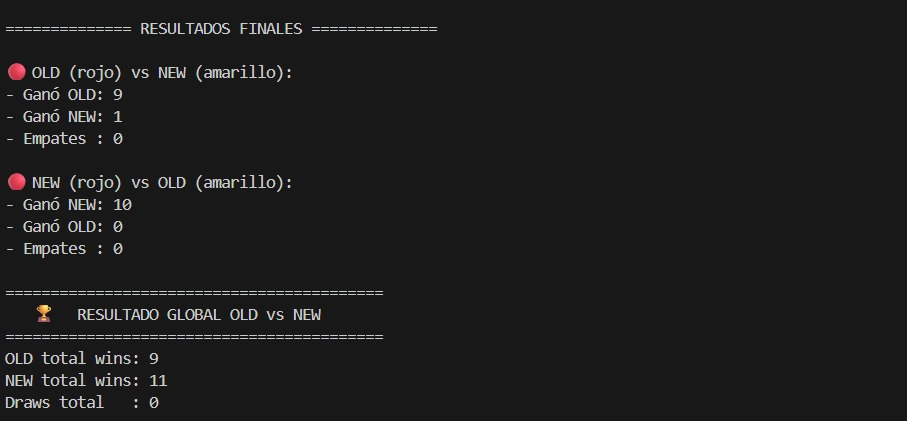

## 7. Conclusiones preliminares (borrador)

- El agente **Magnus OLD** sirve como baseline fuerte basado en MCTS con rollouts aleatorios y heurísticas de victoria/bloqueo inmediato.
- El agente **Magnus NEW** incorpora una tabla **Q(s,a)** entrenada por self-play, que actúa como prior en la selección UCB1, mejorando la calidad de las simulaciones en estados ya visitados durante el entrenamiento.
- El barrido de `simulations` permite observar el compromiso entre **costo computacional** y **desempeño**: más simulaciones suelen mejorar el win rate, pero con retornos decrecientes.
- El duelo directo OLD vs NEW permite validar si el aprendizaje realmente aporta ventaja adicional sobre la versión solo-MCTS.

> Ajusta estos puntos según los resultados reales que obtengas al ejecutar el notebook.
